In [118]:
import numpy as np
import matplotlib.pyplot as plt
from moku.instruments import MultiInstrument, LaserLockBox, DigitalFilterBox, FrequencyResponseAnalyzer, SpectrumAnalyzer
MIM = MultiInstrument('192.168.50.97', force_connect=True, platform_id=4) #192.168.50.97 Moku pro 1 ---- 192.168.50.63 Moku pro 4

# Set up multinstrument mode skeleton

In [119]:
llb = MIM.set_instrument(1, LaserLockBox)
fra = MIM.set_instrument(2, FrequencyResponseAnalyzer)
dfb = MIM.set_instrument(3, DigitalFilterBox)
spa = MIM.set_instrument(4, SpectrumAnalyzer)

In [120]:
connections = [dict(source="Input1", destination="Slot1InA"), # REFL PD to demodulation in laser lock box
               dict(source="Input2", destination="Slot1InB"), # TRANS PD to monitor in laser lock box
               dict(source="Slot1OutA", destination="Slot3InA"), # PID output -control signal- to summing junction in digital filter box
               dict(source="Slot1OutA", destination="Slot4InA"), #control signal to spectrum analyzer
               dict(source="Slot1OutA", destination="Slot2InB"), #control signal to slot B of frequency response analyzer
               dict(source="Slot1OutB",destination="Output3"), # modulation signal to EOM
               dict(source="Slot2OutA", destination="Slot3InB"), #Excitation signal from frequency response analyzer to summing junction in digital filter box
               dict(source="Slot3OutA", destination="Slot2InA"), #control signal plus excitation to slot A of frequency response analyzer
               dict(source="Slot3OutA", destination="Output1"), #control signal plus excitation goes to actuator
               dict(source="Slot3OutA",destination = "Slot4InB") #control signal plus excitation to spectrum analyzer
               ]

MIM.set_connections(connections=connections)

[{'destination': 'Slot1InA', 'source': 'Input1'},
 {'destination': 'Slot1InB', 'source': 'Input2'},
 {'destination': 'Slot2InA', 'source': 'Slot3OutA'},
 {'destination': 'Slot2InB', 'source': 'Slot1OutA'},
 {'destination': 'Slot3InA', 'source': 'Slot1OutA'},
 {'destination': 'Slot3InB', 'source': 'Slot2OutA'},
 {'destination': 'Slot4InA', 'source': 'Slot1OutA'},
 {'destination': 'Slot4InB', 'source': 'Slot3OutA'},
 {'destination': 'Output1', 'source': 'Slot3OutA'},
 {'destination': 'Output3', 'source': 'Slot1OutB'}]

In [121]:
#set inputs
MIM.set_frontend(1,"50Ohm","AC","0dB")
MIM.set_frontend(2,"1MOhm","DC","0dB")

#set outputs
MIM.set_output(1, "0dB")
#MIM.set_output(2, "0dB") #to piezo
MIM.set_output(3, "14dB") #to EOM

{'output_gain': '14dB'}

# Set digital filter box to sum the excitation and control signal then apply an all-pass filter

In [122]:
dfb.set_control_matrix(1, input_gain1=1, input_gain2=1)
dfb.set_control_matrix(2, input_gain1=0, input_gain2=0)

filter_coefficients = [
    [1.0000000000, 1.0000000000, 0.0000000000, 0.0000000000, 0.0000000000, 0.0000000000],
    [1.0000000000, 1.0000000000, 0.0000000000, 0.0000000000, 0.0000000000, 0.0000000000],
    [1.0000000000, 1.0000000000, 0.0000000000, 0.0000000000, 0.0000000000, 0.0000000000],
    [1.0000000000, 1.0000000000, 0.0000000000, 0.0000000000, 0.0000000000, 0.0000000000]]

dfb.set_custom_filter(1, "39.06MHz", coefficients=filter_coefficients) 

dfb.set_input_gain(1,gain = 0)
dfb.set_output_gain(1,gain = 0)

dfb.enable_output(1,True,True)

{'output': True, 'signal': True}

# Configure the laser lock box

In [375]:
scan_freq = 10
scan_amp = 1

In [376]:
llb.set_demodulation(mode="Modulation",frequency=50.68e6,phase=350)
llb.set_aux_oscillator(enable = True,frequency=50.68e6,amplitude=2,output = "OutputB")
llb.set_output(2, signal=False, output=True)

llb.set_scan_oscillator(enable=True,amplitude = scan_amp, frequency = scan_freq, output ="OutputA",shape =  "Triangle")
llb.set_output(1, signal=False, output=True)
llb.set_output_offset(1, offset=0.0)

llb.set_monitor(1, 'ErrorSignal')
llb.set_monitor(2, 'Input2')
llb.set_acquisition_mode(mode="Precision")
llb.set_trigger(type="Edge", source="Scan", level=0,edge="Rising")

{'edge': 'Rising',
 'hf_reject': False,
 'holdoff': 0.0,
 'hysteresis': 0.001,
 'level': 0.0,
 'noise_reject': False,
 'nth_event': 1}

In [385]:
llb.set_timebase(0.0,1/(4*scan_freq))
initialdata = llb.get_data(wait_complete=True)

In [386]:
t = np.array(initialdata['time'])
err = np.array(initialdata['ch1'])
trans = np.array(initialdata['ch2']-np.average(initialdata['ch2']))

In [387]:
avg_err = np.median(err)
t_res = t[np.argmax(trans)]
print(t_res)
V_res = scan_amp*t_res*4*scan_freq

0.012038534400000002


In [388]:
llb.set_setpoint(-avg_err)
llb.set_output_offset(1,offset=V_res)

{'offset': 0.48150000000000004}

In [389]:
llb.set_timebase(-1/(16*scan_freq),1/(16*scan_freq))
data = llb.get_data(wait_complete=True)

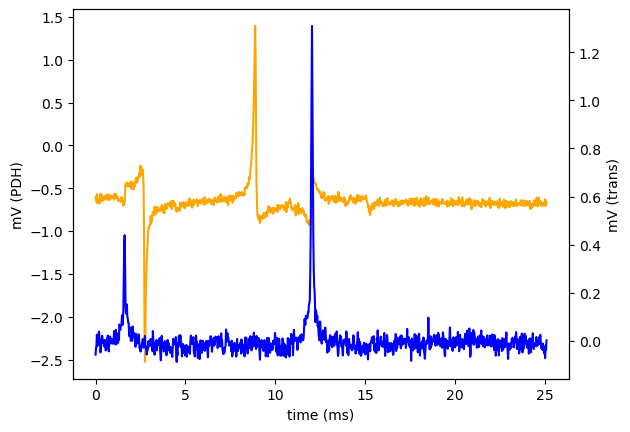

In [390]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('time (ms)')
ax1.set_ylabel('mV (PDH)')
ax1.plot(t*1e3,err*1e3, color = "orange")
ax2 = ax1.twinx()
ax2.set_ylabel('mV (trans)')
ax2.plot(t*1e3,trans*1e3, color = "blue")

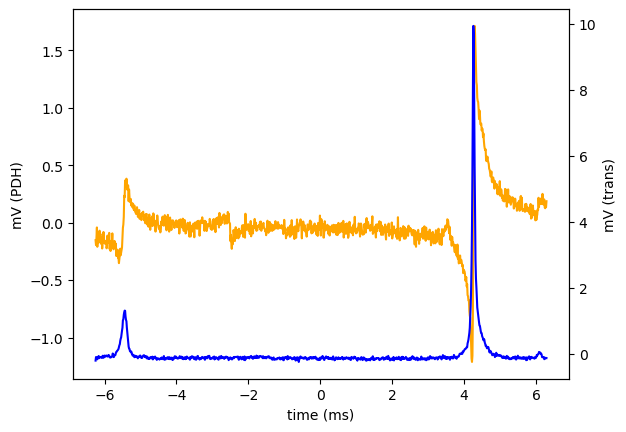

In [391]:
t = np.array(data['time'])
err = np.array(data['ch1'])
avg_err = np.average(err)
trans = np.array(data['ch2']-np.average(data['ch2']))

fig, ax1 = plt.subplots()
ax1.set_xlabel('time (ms)')
ax1.set_ylabel('mV (PDH)')
ax1.plot(t*1e3,err*1e3, color = "orange")
ax2 = ax1.twinx()
ax2.set_ylabel('mV (trans)')
ax2.plot(t*1e3,trans*1e3, color = "blue")

In [393]:
MIM.relinquish_ownership()